In [17]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

In [18]:
def vectorized_stride(array, length, stride):
    start = 0
    max_time = len(array) - length - 1

    sub_windows = (
            start +
            np.expand_dims(np.arange(length), 0) +
            # Create a rightmost vector as [0, V, 2V, ...].
            np.expand_dims(np.arange(max_time + 1, step=stride), 0).T
    )

    return array[sub_windows]


# arr = np.array([[i] * 10 for i in range(10)])
# vectorized_stride(arr, length=4, stride=4)


# def add_features(df):
#     quotes_list = [
#         Quote(d, o, h, l, c, v)
#         for d, o, h, l, c, v
#         in zip(df['Timestamp'], df['Open'], df['High'], df['Low'], df['Close'], df['Volume_(Currency)'])
#     ]
#     ...
#     return ...


def make_standardised_segments(df, segment_len, segment_amp_range, stride):
    segments = vectorized_stride(df.to_numpy(), length=segment_len, stride=stride)
    scaler = MinMaxScaler(feature_range=segment_amp_range)
    return [pd.DataFrame(scaler.fit_transform(segment), columns=df.columns) for segment in segments]


# def tokenize(df, amplitude_range, resolution):
#     # quantities = np.linspace(0, window_height, resolution)
#     interval = amplitude_range / (resolution - 1)
#
#     df = interval * np.round(df / interval)  # nan ok?
#     # df = df.fillna('<NULL>')
#     # df[df.isna().any(axis=1)] = '<NULL>'
#     df = df.astype(str)  # verify this works
#
#     return df

def make_curriculum(df, window_length, window_range, stride):
    return [make_standardised_segments(df[i:], segment_len=window_length, segment_amp_range=window_range, stride=stride)
            for i in range(window_length)]


def ts_train_test_split(df, test_size, gap_size):
    gap_size = int(gap_size)
    train_end = int((1 - test_size) * (len(df) - gap_size))
    return df[:train_end], df[train_end + gap_size:]


def resample(df, freq):
    return df.resample(freq).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        # 'Volume_(BTC)': 'sum',
        'Volume_(Currency)': 'sum',
        # 'Weighted_Price': 'mean',
        # 'Missing': 'sum',
    })

In [125]:


raw_data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', index_col='Timestamp')  # min by min
raw_data.index = pd.to_datetime(raw_data.index, unit='s')

In [131]:


data = raw_data.reindex(pd.date_range(raw_data.index.min(), raw_data.index.max(), freq='min'), fill_value=np.nan)
# data['Missing'] = data.isna().any(axis=1).astype(int)
data = data.interpolate(method='index')
# todo: show how much is interpolated
data = data[['Open', 'High', 'Low', 'Close', 'Volume_(Currency)']].astype(float)

In [147]:

# window_length = int(5 * 30 * 24 / 4)
window_length = 512
stride = 16
window_range = (-1, 1)

train_data, val_data = ts_train_test_split(data, test_size=0.3, gap_size=stride)
val_data, test_data = ts_train_test_split(val_data, test_size=0.5, gap_size=stride)

In [148]:

freq = '15min'
train_data = resample(train_data, freq)
val_data = resample(val_data, freq)
test_data = resample(test_data, freq)
# train_data = add_features(train_data)

In [149]:

# curriculum = []
# for i in range(window_size):
#     curriculum.append(tokenize(quantise(normalise(segment(data, offset=i))), mask))

train_time_period = train_data.index
val_time_period = val_data.index
test_time_period = test_data.index

train_data = np.stack(make_standardised_segments(train_data, window_length, window_range, stride))
val_data = np.stack(make_standardised_segments(val_data, window_length, window_range, stride))
test_data = np.stack(make_standardised_segments(test_data, window_length, window_range, stride))

In [245]:
kernel_size = 5

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(512, 5)),
        # tf.keras.layers.Conv1D(
        #     filters=16, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        # tf.keras.layers.Dropout(rate=0.2),
        # tf.keras.layers.Conv1D(
        #     filters=32, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        # tf.keras.layers.Dropout(rate=0.2),
        # tf.keras.layers.Conv1D(
        #     filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        # tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"
        ),

        tf.keras.layers.Conv1DTranspose(
            filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1DTranspose(
            filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"
        ),
        # tf.keras.layers.Dropout(rate=0.2),
        # tf.keras.layers.Conv1DTranspose(
        #     filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        # tf.keras.layers.Dropout(rate=0.2),
        # tf.keras.layers.Conv1DTranspose(
        #     filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        # tf.keras.layers.Dropout(rate=0.2),
        # tf.keras.layers.Conv1DTranspose(
        #     filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        # ),
        tf.keras.layers.Conv1DTranspose(filters=5, kernel_size=kernel_size, padding="same"),
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_85 (Conv1D)          (None, 256, 32)           832       
                                                                 
 dropout_99 (Dropout)        (None, 256, 32)           0         
                                                                 
 conv1d_86 (Conv1D)          (None, 128, 16)           2576      
                                                                 
 conv1d_transpose_102 (Conv1  (None, 256, 16)          1296      
 DTranspose)                                                     
                                                                 
 dropout_100 (Dropout)       (None, 256, 16)           0         
                                                                 
 conv1d_transpose_103 (Conv1  (None, 512, 32)          2592      
 DTranspose)                                         

In [246]:

history = model.fit(
    train_data,
    train_data,
    batch_size=128,
    epochs=50,
    validation_data=(val_data, val_data),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
    verbose=1
)


Epoch 1/50
111/111 [==============================] - 5s 42ms/step - loss: 0.0725 - val_loss: 0.0158
Epoch 2/50
111/111 [==============================] - 4s 40ms/step - loss: 0.0225 - val_loss: 0.0128
Epoch 3/50
111/111 [==============================] - 5s 44ms/step - loss: 0.0178 - val_loss: 0.0120
Epoch 4/50
111/111 [==============================] - 5s 42ms/step - loss: 0.0151 - val_loss: 0.0108
Epoch 5/50
111/111 [==============================] - 5s 41ms/step - loss: 0.0130 - val_loss: 0.0091
Epoch 6/50
111/111 [==============================] - 5s 42ms/step - loss: 0.0115 - val_loss: 0.0089
Epoch 7/50
111/111 [==============================] - 4s 38ms/step - loss: 0.0106 - val_loss: 0.0088
Epoch 8/50
111/111 [==============================] - 4s 36ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 9/50
111/111 [==============================] - 4s 37ms/step - loss: 0.0094 - val_loss: 0.0084
Epoch 10/50
111/111 [==============================] - 4s 37ms/step - loss: 0.0089 - val_lo

In [247]:
model.evaluate(test_data, test_data)

94/94 [==============================] - 1s 5ms/step - loss: 0.0077


0.007695815060287714

94/94 [==============================] - 0s 5ms/step


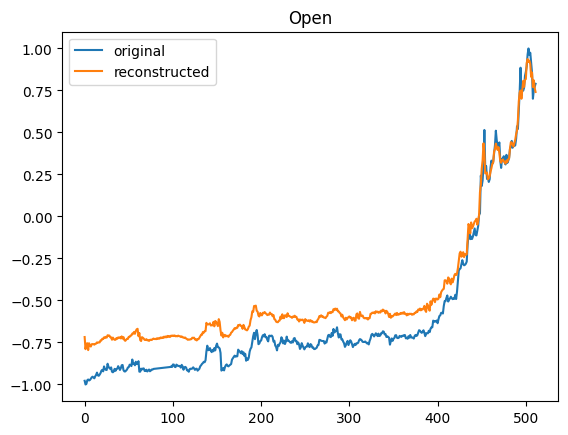

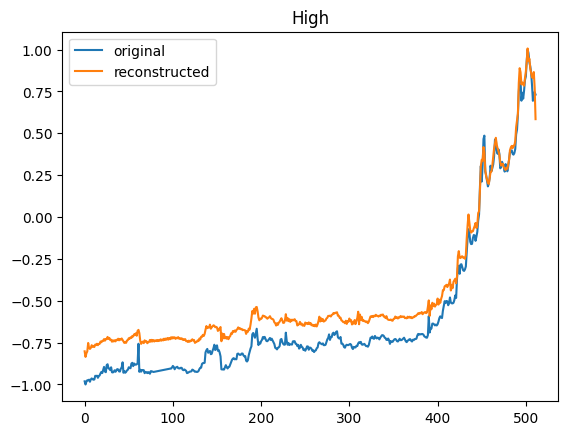

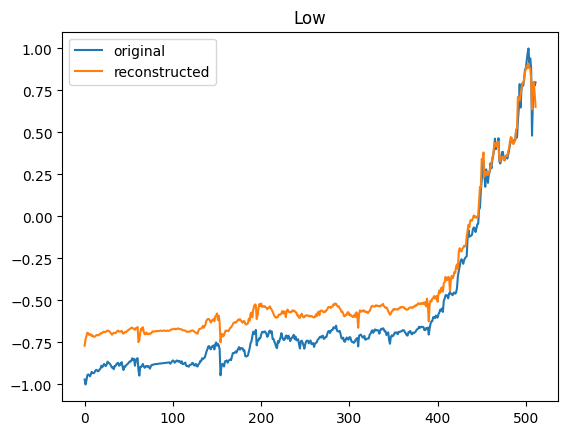

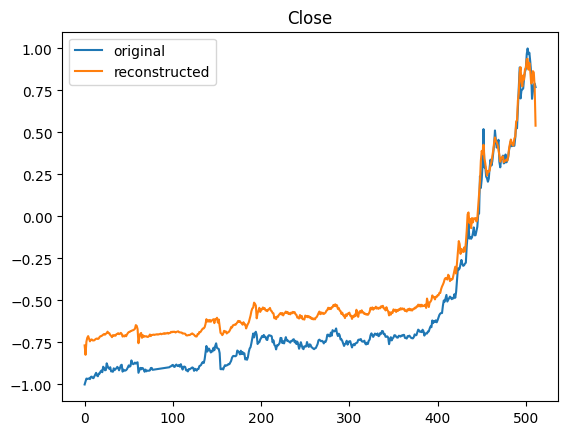

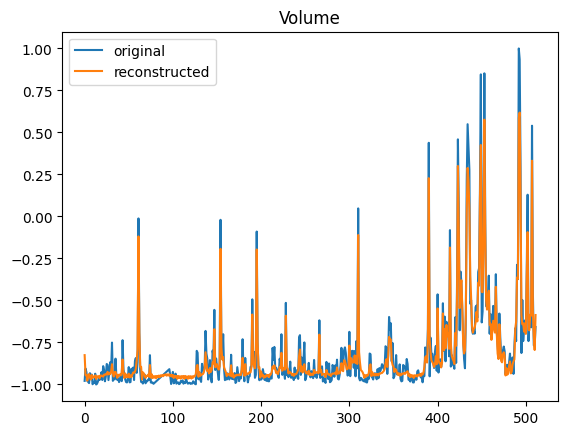

In [254]:
import matplotlib.pyplot as plt
import os
import pickle

output_dir = 'trainingLog'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, 'trainHistoryDict.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

test_pred = model.predict(test_data)

for i, title in enumerate(['Open', 'High', 'Low', 'Close', 'Volume']):
    plt.title(title)
    plt.plot(test_data[1000, :, i], label='original')
    plt.plot(test_pred[1000, :, i], label='reconstructed')
    plt.legend()
    plt.savefig(os.path.join(output_dir, title + '.png'))
    plt.show()

In [250]:
# from components.transformer import TSTransformerAutoEncoder
#
# autoencoder = TSTransformerAutoEncoder(vocab_size=1000,
#                                        input_shape=(512, 5),
#                                        d_embedding=64,
#                                        d_compressed=51,
#                                        n_layers=4,
#                                        FFN_units=2048,
#                                        n_heads=8,
#                                        dropout_rate=0.1)

# autoencoder.compile(optimizer='adam', loss='mae')
